In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from tqdm import trange
from dataclasses import dataclass
import csv

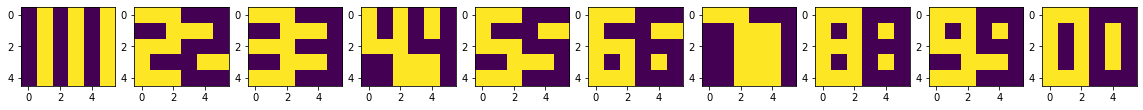

In [2]:
data_rows = {
    "e":  {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1},
    "r":  {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0},
    "c":  {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1},
    "cr": {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0},
    "l":  {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1},
    "lr": {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0},
    "lc": {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1},
    "f":  {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0},
    "off":{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
}
numbers = {
    1: "c c c c c",
    2: "f r f l f",
    3: "f r f r f",
    4: "lr lr f r r",
    5: "f l f r f",
    6: "f l f lr f",
    7: "f r r r r",
    8: "f lr f lr f",
    9: "f lr f r f",
    0: "f lr lr lr f",
}
empty = np.array([[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1]])

numbers_rows = {k: [data_rows[vv] for vv in v.split(" ")] for k, v in numbers.items()}

fig, axs = plt.subplots(1, 10, figsize=(20,20))
for ax, n in zip(axs, numbers_rows.values()):
    ax.imshow(pd.DataFrame(n).values)

In [3]:
def draw_network(net):
    import networkx as nx
    edges = []
    pos = {}
    n_in = {}
    for node, (_, priority, listen, cast) in net.nodes.iterrows():
        if listen is not None:
            try:
                iter(listen)
            except:
                listen = [listen]
            for l in listen:
                edges.append((l, node))
        if cast is not None:
            try:
                iter(cast)
            except:
                cast = [cast]
            for c in cast:
                edges.append((node, c))
        if priority not in n_in:
            n_in[priority] = 0
        pos[node] = (priority, n_in[priority])
        n_in[priority] += 0.5
    G = nx.DiGraph()
    G.add_edges_from(edges)
    plt.figure(figsize=(15,15))
    options = {
        "font_size": 12,
        "node_size": 300,
        "node_color": "white",
        "edgecolors": "blue",
        "linewidths": 2,
        "width": 2,
        "connectionstyle": 'arc3, rad = 0.3'
    }
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    nx.draw_networkx(G, pos, **options)
    plt.show()

In [105]:
class Network:
    def __init__(self, *, 
        inputs_l = 1, 
        labels = None,
        dt = 1, 
        tau_inhibitory = 3, 
        tau_refractory = 5, 
        tau_leak = 10, 
        tau_ltp = 5, 
        thres = 200,
        ainc = 30, 
        adec = -15, 
        wmax = 255,
        wmin = 1,
        learning = True
    ):
        #print(f"{inputs_l=},{labels=},{dt=},{tau_inhibitory=},{tau_refractory=},{tau_leak=},{tau_ltp=},{thres=},{ainc=},{adec=},{wmax=},{wmin=}")
        if labels is None:
            labels = range(inputs_l)
        self.labels_dict = dict(zip(labels, range(inputs_l)))
        self.values = pd.DataFrame(columns=range(inputs_l))
        input_nodes = [
            {
                "type": "input",
                "priority": 0,
                "listening": None,
                "broadcasting": None
            } for _ in range(inputs_l)]
        self.nodes = pd.DataFrame(data=input_nodes, columns=["type", "priority", "listening", "broadcasting"])
        self.weights = pd.DataFrame(columns=["weights", "inhibited"])
        self.node_to_weights_entry = {}
        self.dt = dt
        self.tau_refractory = tau_refractory
        self.tau_inhibitory = tau_inhibitory
        self.ltp_thres = np.exp(-tau_ltp/tau_leak)
        self.leak = np.exp(-self.dt/tau_leak)
        self.thres = thres
        self.ainc = ainc
        self.adec = adec
        self.wmin = wmin
        self.wmax = wmax
        self.learning = learning
        
    def new_layer(self, width, weights=None, labels=None):
        nnodes = []
        nweights = []
        priority = self.nodes["priority"].max()+1
        if priority == 1: #первый слой
            inputs = np.array(self.nodes.loc[self.nodes["priority"]==0].index.tolist())
        else: #нужно пропустить потенцирующие ноды
            inputs = np.array(self.nodes.loc[self.nodes["priority"]==priority-2].index.tolist())
        
            
        if weights is None:
            weights = np.array([np.random.randint(self.wmin, self.wmax, inputs.shape[0]) for _ in range(width)])
            
        if weights.shape != (width, inputs.shape[0]):
            raise Exception(f"Требуется массив {(width, inputs.shape[0])}, получено {weights.shape}")
            
        node_id = self.nodes.index.size
        summator_id = node_id+inputs.shape[0]
        postsynaptic_id = node_id+inputs.shape[0]+1
        
        presynaptic_range = np.arange(node_id, node_id+inputs.shape[0])
        layer_summators_range = np.arange(width)*(3)+summator_id
        layer_postsynaptic_range = np.arange(width)*(3)+postsynaptic_id
        
        for i in inputs:
            nnodes.append(
                {
                    "type": "presynaptic",
                    "listening": i,
                    "broadcasting": None,
                    "priority": priority
                }
            )
                
        
        if labels is None:
            labels = layer_postsynaptic_range
        self.labels_dict.update(dict(zip(layer_postsynaptic_range, labels)))
        
        for w in weights:
            nnodes.append(
                {
                    "type": "summator",
                    "listening": presynaptic_range,
                    "broadcasting": postsynaptic_id,
                    "priority": priority+1
                }
            )
            nweights.append(
                {
                    "node": summator_id,
                    "weights": w,
                    "inhibited": -1
                }
            )
            
            nnodes.append(
                {
                    "type": "postsynaptic",
                    "listening": summator_id,
                    "broadcasting": layer_summators_range[layer_summators_range != summator_id],
                    "priority": priority+2
                }
            )
            nnodes.append(
                {
                    "type": "potentiating",
                    "listening": presynaptic_range,
                    "broadcasting": summator_id,
                    "priority": priority+3
                }
            )
            
            summator_id += 3
            postsynaptic_id += 3
            
        self.nodes = pd.concat((self.nodes, pd.DataFrame(nnodes))).reset_index(drop=True)
        self.weights = pd.concat((self.weights, pd.DataFrame(nweights).set_index("node", drop=True)))
    
    def make_recurrent(self):
        max_priority = self.nodes["priority"].max()
        last_layer_output = np.array(self.nodes.loc[self.nodes["priority"]==max_priority-1].index.tolist())
        first_layer_summators = np.array(self.nodes.loc[self.nodes["priority"]==2].index.tolist())
        nnodes = [
            {
                "type": "presynaptic",
                "listening": o,
                "broadcasting": None,
                "priority": 5
            } for o in last_layer_output
        ]
        recurrent_presynaptic_indexes = np.arange(self.nodes.index.size, self.nodes.index.size+last_layer_output.shape[0])
        nweights = self.weights.to_dict()
        nnodes = pd.concat((self.nodes, pd.DataFrame(nnodes))).reset_index(drop=True).to_dict()
        for s in first_layer_summators:
            nweights["weights"][s] = np.concatenate((nweights["weights"][s], np.random.randint(self.wmin, self.wmax, last_layer_output.shape[0])))
            nnodes["listening"][s] = np.concatenate((nnodes["listening"][s], recurrent_presynaptic_indexes))
            nnodes["listening"][s+2] = np.concatenate((nnodes["listening"][s+2], recurrent_presynaptic_indexes))
        self.nodes = pd.DataFrame(nnodes)
        self.weights = pd.DataFrame(nweights)
    
    def stepwise_generator(self, data):
        vals = pd.Series(np.zeros(data.shape[1]))
        for t in data.index:
            vals_z = vals
            vals = data.iloc[t].copy()
            for node in self.nodes.sort_values("priority").index.tolist():
                (node_type, _, listen, cast) = self.nodes.loc[node, :]
                n_val = vals[node]
                if node_type == "presynaptic":
                    if vals.at[listen] >= vals_z.at[node]:
                        n_val = vals.at[listen]
                    else:
                        n_val = vals_z.at[node]*self.leak
                elif node_type == "summator":
                    n_val = (vals[listen].values*self.weights.at[node, "weights"]).sum()+
                elif node_type == "postsynaptic":
                    n_val = 0
                    if self.weights.at[listen, "inhibited"] < t:
                        n_val = int(vals.at[listen]>self.thres)
                    if n_val:
                        self.weights.at[listen, "inhibited"] = t+self.tau_refractory
                        for b in cast:
                            self.weights.at[b, "inhibited"] = max(t+self.tau_inhibitory, self.weights.at[b, "inhibited"]+self.tau_inhibitory)
                elif node_type == "potentiating":
                    if vals[node-1] and self.learning:
                        nw = self.weights.at[cast, "weights"] + np.where(vals[listen]>self.ltp_thres, self.ainc, self.adec)
                        nw = np.where(nw>self.wmax, self.wmax, nw)
                        self.weights.at[cast, "weights"] = np.where(nw<self.wmin, self.wmin, nw)

                vals[node] = n_val
            yield vals
                
    def feed_csv(self, data_csv, out_csv, data_timestep=1):
        self.weights["inhibited"].values[:] = 0
        time_scale_factor = data_timestep//self.dt
        with open(data_csv, "r", newline='') as f:
            datareader = csv.DictReader(f, delimiter='\t')
            #строки будут повторяться чтобы привести данные к временному шагу расчёта
            data = pd.DataFrame([{int(k): float(v) for k,v in row.items()} for row in datareader for dt in np.arange(time_scale_factor)], columns=self.nodes.index).fillna(0)
        s = self.stepwise_generator(data)
        out = [u.to_dict() for u in s]
        self.values = pd.DataFrame(out)
        with open(out_csv, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=self.values.columns)
            writer.writeheader()
            for row in out:
                writer.writerow(row)
        return pd.DataFrame(out)
    
    def feed_raw(self, data_raw, out_csv):
        self.weights["inhibited"].values[:] = 0
        data = pd.DataFrame(data_raw, columns=self.nodes.index).fillna(0)
        s = self.stepwise_generator(data)
        out = [u.to_dict() for u in s]
        self.values = pd.DataFrame(out)
        with open(out_csv, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=self.values.columns)
            writer.writeheader()
            for row in out:
                writer.writerow(row)
        return pd.DataFrame(out)
    


In [111]:
params = {
    "inputs_l": 6,
    "dt": 1, 
    "tau_leak": 100, 
    "tau_inhibitory": 0, 
    "tau_refractory": 15, 
    "tau_ltp": 1, 
    "thres": 700,
    "ainc": 30, 
    "adec": -15, 
    "wmax": 255, 
    "wmin": 1,
    "learning": False
}
weights_rows = np.array([
    [1, 1, 1, 255, 255, 255],
    [1, 1, 255, 255, 255, 1],
    [1, 255, 1, 255, 1, 255],
    [1, 255, 255, 255, 1, 1],
    [255, 1, 1, 1, 255, 255],
    [255, 1, 255, 1, 255, 1],
    [255, 255, 1, 1, 1, 255],
    [255, 255, 255, 1, 1, 1]
])
labels_rows = [
    "e",
    "r",
    "c",
    "cr",
    "l",
    "lr",
    "lc",
    "f"
]
weights_digits = np.array([
    [1, 1, 700, 1, 1, 1, 1, 1],
    [255, 1, 1, 1, 255, 1, 1, 255],
    [1, 1, 1, 1, 1, 351, 1, 351]
])
labels_digits = [
    "one",
    "two",
    "zero"
]
net = Network(**params)
net.new_layer(8, weights=weights_rows, labels=labels_rows)
net.new_layer(3, weights=weights_digits, labels=labels_digits)
#net.make_recurrent()

In [107]:
net.nodes

,type,priority,listening,broadcasting
0,input,0,None,None
1,input,0,None,None
2,input,0,None,None
3,input,0,None,None
4,input,0,None,None
5,input,0,None,None
6,presynaptic,1,0,None
7,presynaptic,1,1,None
8,presynaptic,1,2,None
9,presynaptic,1,3,None


In [74]:
net.weights

,weights,inhibited
12,"[1, 1, 1, 255, 255, 255]",-1
15,"[1, 1, 255, 255, 255, 1]",-1
18,"[1, 255, 1, 255, 1, 255]",-1
21,"[1, 255, 255, 255, 1, 1]",-1
24,"[255, 1, 1, 1, 255, 255]",-1
27,"[255, 1, 255, 1, 255, 1]",-1
30,"[255, 255, 1, 1, 1, 255]",-1
33,"[255, 255, 255, 1, 1, 1]",-1
44,"[1, 1, 255, 1, 1, 1, 1, 1]",-1
47,"[255, 1, 1, 1, 255, 1, 1, 255]",-1


In [75]:
net.labels_dict

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 13: 'e',
 16: 'r',
 19: 'c',
 22: 'cr',
 25: 'l',
 28: 'lr',
 31: 'lc',
 34: 'f',
 45: 'one',
 48: 'two',
 51: 'zero'}

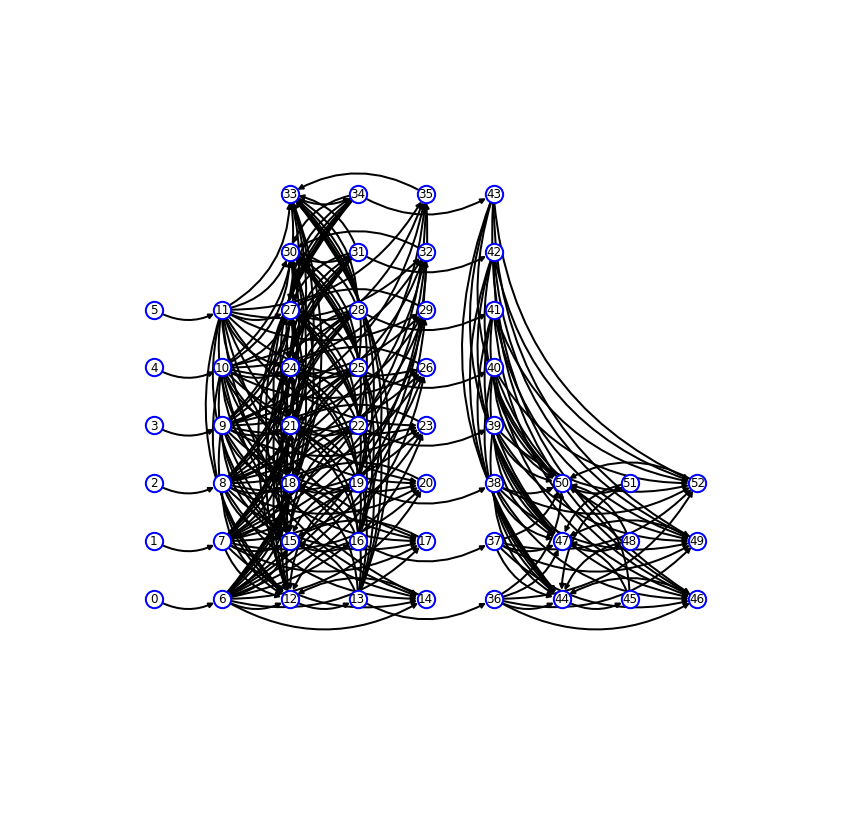

In [76]:
draw_network(net)

In [112]:
data = []
rows = list(numbers_rows.values())
for i in range(10):
    #data.append(rows[np.random.randint(len(rows))])
    data += [x for x in numbers_rows[np.random.randint(3)] for _ in range(10)]
    for i in range(150):
        data.append(data_rows["off"])
out = net.feed_raw(data, "output.csv")

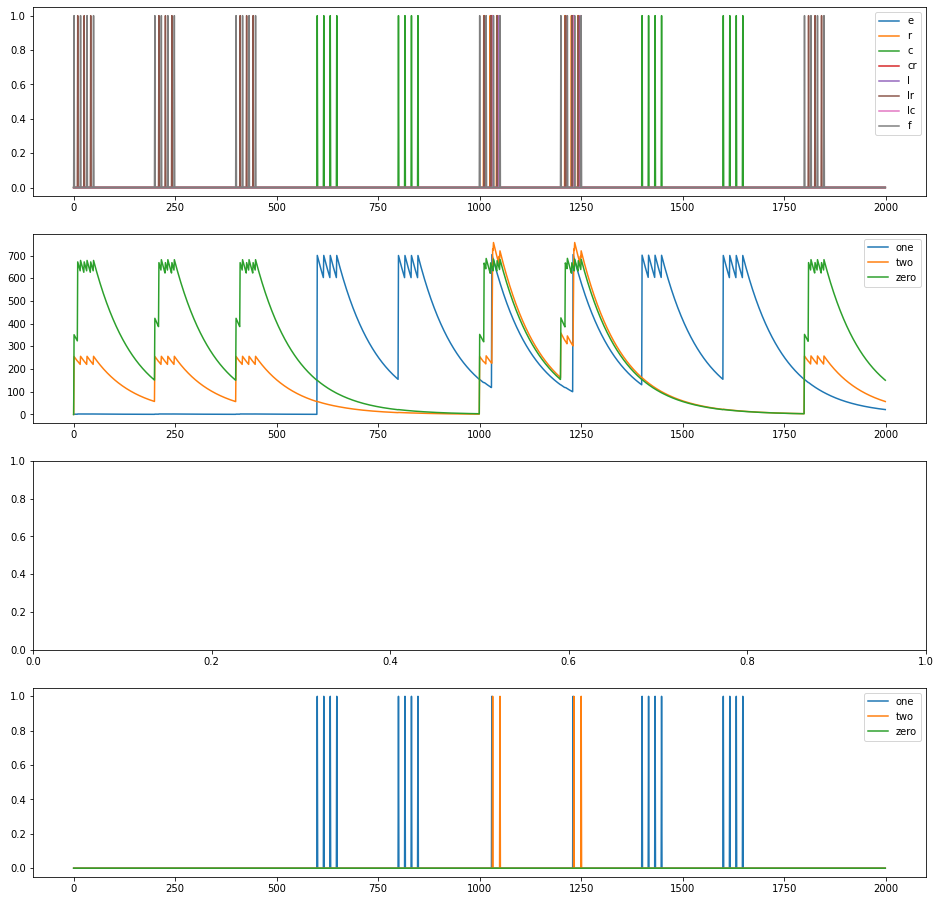

In [113]:
in_nodes = net.nodes.loc[net.nodes["type"] == "input"].index
pre_nodes = net.nodes.loc[net.nodes["type"] == "presynaptic"].index
summ_nodes = net.nodes.loc[net.nodes["type"] == "summator"].index
rows_nodes = [13,16,19,22,25,28,31,34]
digits_summ = [44,47,50]
digits_nodes = [45,48,51]

time = out.index.tolist()

fig, ax = plt.subplots(4,1,figsize=(16,16))

for sumn in rows_nodes:
    ax[0].plot(time, out[sumn].values)
    ax[0].legend(labels_rows)
for pren in digits_summ:
    ax[1].plot(time, out[pren].values)
    ax[1].legend(labels_digits)
for postn in digits_nodes:
    ax[3].plot(time, out[postn].values)
    ax[3].legend(labels_digits)

In [84]:
net.weights

,weights,inhibited
12,"[1, 1, 1, 255, 255, 255]",597
15,"[1, 1, 255, 255, 255, 1]",612
18,"[1, 255, 1, 255, 1, 255]",597
21,"[1, 255, 255, 255, 1, 1]",597
24,"[255, 1, 1, 1, 255, 255]",610
27,"[255, 1, 255, 1, 255, 1]",597
30,"[255, 255, 1, 1, 1, 255]",597
33,"[255, 255, 255, 1, 1, 1]",603
44,"[1, 1, 255, 1, 1, 1, 1, 1]",0
47,"[255, 1, 1, 1, 255, 1, 1, 255]",0


In [96]:
net.leak

0.8187307530779818

In [98]:
np.exp(-1/100)

0.9900498337491681